# Progetto di Social Computing

a.a. 2022/2023

## Attività preliminari

### Librerie e costanti

In [1]:
# Import delle librerie utilizzate
import os, tweepy, json
import networkx as nx 
import pandas as pd 
import numpy as np 
import random as rn
import networkx as nx
import matplotlib.pyplot as plt 
from pyvis.network import Network
from pylab import rcParams


In [2]:
# Cartelle di salvataggio
data_folder = "./data"
out_folder = "./out"
graph_folder = "./graphs"

### Funzioni

In [3]:
# Salvataggio in locale
def serialize_json(folder, filename, data):
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
    
    with open(f"{folder}/{filename}", "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent = 4)
        f.close()
    print(f"Data serialized to path: {folder}/{filename}")

In [4]:
# Lettura da locale
def read_json(path):
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as file:
            data = json.load(file)
        print(f"Data read from path: {path}")
        return data
    else:
        print(f"No data found at path: {path}")
        return {}

In [6]:
# Somma dei numeri di tweet prodotti in un intervallo di tempo
def sum_tweets_count(tweet_groups):
    sum = 0

    for tweet_count in tweet_groups:
        sum += tweet_count["tweet_count"]
    
    return sum

In [21]:
def normalize_into(user, root_distance, destination):
    normalized = {
        "name" : user["name"],
        "username" : user["username"],
        "description" : user["description"],
        "public_metrics" : user["public_metrics"],
        "protected" : user["protected"]
    }

    # Se user non è protetto, si possono aggiungere i dettagli aggiuntivi
    if (root_distance < 2 and not user["protected"]):
        # Si estraggono le ids dei follower di 'follower'
        f_ids = []
        for f in user["followers"]:
            f_ids.append(f["id"])
    
        normalized["last_week_tweets_count"] = user["last_week_tweets_count"]
        normalized["followers"] = f_ids
    
    # Non si aggiorna se l'utente è già definito
    if user["id"] not in destination:
        destination[user["id"]] = normalized

### Credenziali Twitter API

In [6]:
# Caricamento credenziali da JSON
api_access = read_json("./api_access.json")

Data read from path: ./api_access.json


## Recupero dei follower e dei follower dei follower

### Recupero dei follower

Si vogliono recuperare, utilizzando la libreria `tweepy`, tutti i follower dell'utente *@KevinRoitero*, corredati delle seguenti informazioni:

* attributi di default;
* descrizione del profilo;
* metriche pubbliche dell'account;
* se l'account è protetto

In [18]:
 # Si inizializza il client
client = tweepy.Client(bearer_token=api_access["bearer_token"])

username = "KevinRoitero"
all_user_followers = []

# Si recuperano e memorizzano le informazioni dell'utente
response = client.get_user(username = username, user_fields=["description", "protected", "public_metrics"])
user = dict(response.data)

# Si recuperano e memorizzano i follower dell'utente
response = client.get_users_followers(user["id"], user_fields=["description", "protected", "public_metrics"], 
                                      max_results=150) # max_results = 150 perché i follower dell'utente sono nell'ordine di 130
for follower in response.data:
    all_user_followers.append(dict(follower))

# Si associano i follower trovati all'utente di partenza
user["followers"] = all_user_followers

# Si serializza su JSON il risultato ottenuto
serialize_json(data_folder, "user_followers.json", user)

Data serialized to path: ./data/user_followers.json


### Aggiunta del numero di tweet prodotti nell'ultima settimana

Ai follower trovati, si vuole aggiungere il numero di tweet pubblicati nell'ultima settimana. Per avere uniformità, troveremo anche il numero di tweet pubblicati nell'ultima settimana dall'utente *@KevinRoitero*.

In [19]:
# Si sceglie l'utilizzo dello stesso client di partenza, o comunque senza la possibilità di mettersi in attesa, 
# perché numero_richieste < 300, dove 300 è il numero massimo di richieste per l'endpoint get_recent_tweets_count()
client = tweepy.Client(bearer_token=api_access["bearer_token"])

# Si caricano i dati dell'utente e quelli dei suoi follower
user = read_json(data_folder+"/user_followers.json")

# Si memorizza il numero di tweet pubblicati dall'utente nell'ultima settimana
response = client.get_recent_tweets_count(query="from:"+user["username"], granularity="day")
user["last_week_tweets_count"] = sum_tweets_count(response.data)

# Si ripete lo stesso per i follower dell'utente
for follower in user["followers"]:
    if(not follower["protected"]): # non si può accedere ai tweet di un utente 'protected'
        response = client.get_recent_tweets_count(query="from:"+follower["username"], granularity="day")
        follower["last_week_tweets_count"] = sum_tweets_count(response.data)

# Si serializza su JSON il risultato ottenuto
serialize_json(data_folder, "followers_last_week_tweets.json", user)

Data read from path: ./data/user_followers.json
Data serialized to path: ./data/followers_last_week_tweets.json


### Recupero dei follower dei follower

Per ciascun follower di *@KevinRoitero* avente almeno 1 follower e non `protected`, si vogliono scaricare le seguenti informazioni:

* attributi di default;
* descrizione del profilo;
* metriche pubbliche dell'account;
* se l'account è protetto

L'approccio che è stato seguito è quello di un download *parallelo*, ossia ciascun collaboratore al progetto si è preso in carico di scaricare una porzione di follower dei follower di *@KevinRoitero*.

In [7]:
# Si impone al client di attendere nel caso di raggiungimento del limite delle richieste
client = tweepy.Client(bearer_token=api_access["bearer_token"], wait_on_rate_limit=True)

# Si caricano i dati dell'utente e quelli dei suoi follower
user = read_json(data_folder+"/followers_last_week_tweets.json")

# Parallelizzando il calcolo, si decide di partizionare tra collaboratori il numero di follower
all_followers = np.array(user["followers"])

f_num = user["public_metrics"]["followers_count"]
start = f_num*api_access["id"] // 4
end = f_num*(api_access["id"]+1) // 4

# Si vogliono memorizzare solamente i follower di responsabilità del collaboratore
interval_followers = []

# Si scaricano i follower dei follower nell'intervallo del collaboratore
for i in range(start, end):
    # Si considera l'i-esimo follower
    follower = all_followers[i]

    # Se l'i-esimo follower non è protetto e ha dei follower, li scarico
    if (not follower["protected"] and follower["public_metrics"]["followers_count"] > 0):
        for all_follower_followers in tweepy.Paginator(client.get_users_followers, id = follower["id"],
                                                       user_fields=["description", "protected", "public_metrics"], max_results = 1000):
            parsed_followers = []
            
            for ff in all_follower_followers.data:
                # L'oggetto User deve essere interpretato
                parsed_follower = {
                    "id" : ff["id"],
                    "public_metrics" : ff["public_metrics"],
                    "description" : ff["description"],
                    "name" : ff["name"],
                    "protected" : ff["protected"],
                    "username" : ff["username"]
                }
                parsed_followers.append(parsed_follower)
            
            follower["followers"] += parsed_followers
    
    # Aggiungo il follower (arricchito dei suoi follower) nella lista di follower di competenza del collaboratore
    interval_followers.append(follower)

# Si salva la porzione di follower scaricata
serialize_json(data_folder, "f_of_f_"+str(api_access["id"])+".json", list(interval_followers))

Data read from path: ./data/followers_last_week_tweets.json


Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 893 seconds.
Rate limit exceeded. Sleeping for 891 seconds.


Data serialized to path: ./data/f_of_f_2


Si uniscono ora i file generati dai diversi collaboratori in un unico file JSON.

In [15]:
# Si carica il JSON con le informazioni su @KevinRoitero
user = read_json(data_folder+"/followers_last_week_tweets.json")
followers = []

for i in range(0, 4):
    # Si caricano i follower individuati dal collaboratore i
    partial_followers = read_json(data_folder+"/f_of_f_"+str(i)+".json")
    
    # Si concatenano all'elenco completo dei follower
    followers += partial_followers

# Si aggiornano i dati sui follower di @KevinRoitero
user["followers"] = followers

# Si serializza il risultato ottenuto
serialize_json(data_folder, "user_complete.json", user)

Data read from path: ./data/followers_last_week_tweets.json
Data read from path: ./data/f_of_f_0.json
Data read from path: ./data/f_of_f_1.json
Data read from path: ./data/f_of_f_2.json
Data read from path: ./data/f_of_f_3.json
Data serialized to path: ./data/user_complete.json


### Riformattazione del JSON finale

Al fine di essere conformi alle specifiche della consegna, si decide di ristrutturare (ossia modificarne la presentazione, pur mantenendo invariate le informazioni al suo interno) il JSON `user_complete.json` definito in precedenza.

Il formato che è stato ritenuto come più opportuno, sia per un'efficienza di archiviazione che di computazione (importante per le sezione successive), è il seguente:
```json
{
    ...
    id (int) : {
        "name" : str,
        "username" : str,
        "description" : int,
        "public_metrics" : {
            "followers_count" : int,
            "following_count" : int,
            "tweet_count" : int,
            "listed_count" : int
        },
        "protected" : bool,
        ("last_week_tweets_count" :int,)
        ("followers" : [
            ...
            f_id (int),
            ...
        ])
    }
    ...
}
```

Dove `id` rappresenta l'identificativo univoco di un utente, le cui informazioni sono state scaricate nei passi precedenti, ed `f_id` rappresenta l'identificativo di un follower di `id`.

È doveroso far notare che, per come sono stati scaricati gli utenti, solamente coloro che o sono *@KevinRoitero* o sono suoi follower (non `protected`) presentano il campo `last_week_tweets_count` ed il campo `followers` (da cui le parentesi tonde nello schema).

In [22]:
# Si carica il JSON completo, non formattato
root_user = read_json(data_folder+"/user_complete.json")

nodes = {} # JSON finale

normalize_into(user = root_user, root_distance=0, destination = nodes)

# Si fa la stessa cosa per follower di @KevinRoitero
for follower in root_user["followers"]:
    normalize_into(user = follower, root_distance = 1, destination = nodes)

# ... e per i follower dei follower
for follower in root_user["followers"]:
    if (not follower["protected"]):
        for ff in follower["followers"]:
            normalize_into(user = ff, root_distance = 2, destination = nodes)

# Si serializza il JSON ben formattato
serialize_json(data_folder, "users_final.json", nodes)

Data read from path: ./data/user_complete.json
Data serialized to path: ./data/users_final.json


Si consideri che, per come è stato costruito, il file `users_final.json` presenta una struttura ordinata:

1. Al primo posto vi sonoi dettagli sul profilo di *@KevinRoitero*;
2. dal secondo posto fino al 134-esimo vi sono i follower di *@KevinRoitero*;
3. dal 135-esimo posto in poi vi sono i follower dei follower di *@KevinRoitero*.

## Creazione della rete sociale diretta

### Aggiunta dei nodi

Come nodi si vogliono avere *@KevinRoitero* ed i suoi follower ed ogni nodo deve rispettare le seguenti caratteristiche:

* il suo `id` deve essere uguale all'`id` del profilo utente;
* deve avere come attributi:
    * lo username;
    * la descrizione;
    * il numero di follower del profilo.

In [5]:
# Si crea un grafo diretto vuoto
social_graph = nx.DiGraph()

# Si considera l'insieme dei profili utente
users = read_json(data_folder+"/users_final.json")

# La struttura del file permette di fare un inserimento "ordinato"
added = 0
for id in users:
    user = users[id]
    social_graph.add_node(int(id), username = user["username"], 
                              description = user["description"], 
                              followers_count = user["public_metrics"]["followers_count"])
    
    added += 1
    # Il 134-esimo utente è l'ultimo follower di @KevinRoitero
    if(added == 134):
        break

# N.B.: questo trucchetto dell'inserimento ordinato è possibile solamente grazie al fatto che la funzione read_json() ed il costrutto for,
#       rispettivamente, caricano in memoria principale le informazioni in ordine di apparizione ed iterano su di esse rispettando ancora
#       il loro ordine di apparizione. Se questi dettagli implementativi dovessero cambiare, sarebbe necessario apportare modifiche anche
#       a questa soluzione.

Data read from path: ./data/users_final.json


### Aggiunta degli archi

Al grafo definito precedentemente si vogliono aggiungere archi $(v,w)$ tra due nodi $v$ e $w$ se e solo se il profilo corrispondente a $v$ è follower del profilo corrispondente a $w$.

In [6]:
# Si ereditano le variabili 'social_graph' e 'users' dal chunk precedente
for v in social_graph.nodes:
    for w in social_graph.nodes:
        if (not v == w and not users[str(w)]["protected"] and v in users[str(w)]["followers"]):
            social_graph.add_edge(v, w)

In [17]:
# Serializzazione del grafo
graph_dict = nx.node_link_data(social_graph)
serialize_json(graph_folder, "social_graph.json", graph_dict)

Data serialized to path: ./graphs/social_graph.json


### Generazione grafo con Preferential Attachment 
Generazione del secondo grafo secondo gli step: 
  - conversione del grafo in versione indiretta 
  - uso della funzione barabasi_albert_graph per ottenere un grafo con il preferential attachment con:
    - grafo con il doppio dei nodi 
    - ogni nodo con due archi uscenti 

In [9]:
# computazione del secondo grafo 
number_of_nodes = social_graph.number_of_nodes()
undirected_graph = social_graph.to_undirected()
# definizione del secondo grafo 
preferential_graph = nx.barabasi_albert_graph(number_of_nodes*2, 2, initial_graph = undirected_graph)

In [19]:
# Serializzazione del grafo
graph_dict = nx.node_link_data(preferential_graph)
serialize_json(graph_folder, "preferential_graph.json", graph_dict)

Data serialized to path: ./graphs/preferential_graph.json


### Visualizzazione statica NetworkX con layout Fruchterman Reigold

Per il grafo diretto la dimensione dei nodi dipende dal grado in ingresso del nodo 

In [14]:
rcParams['figure.figsize'] = 12, 12

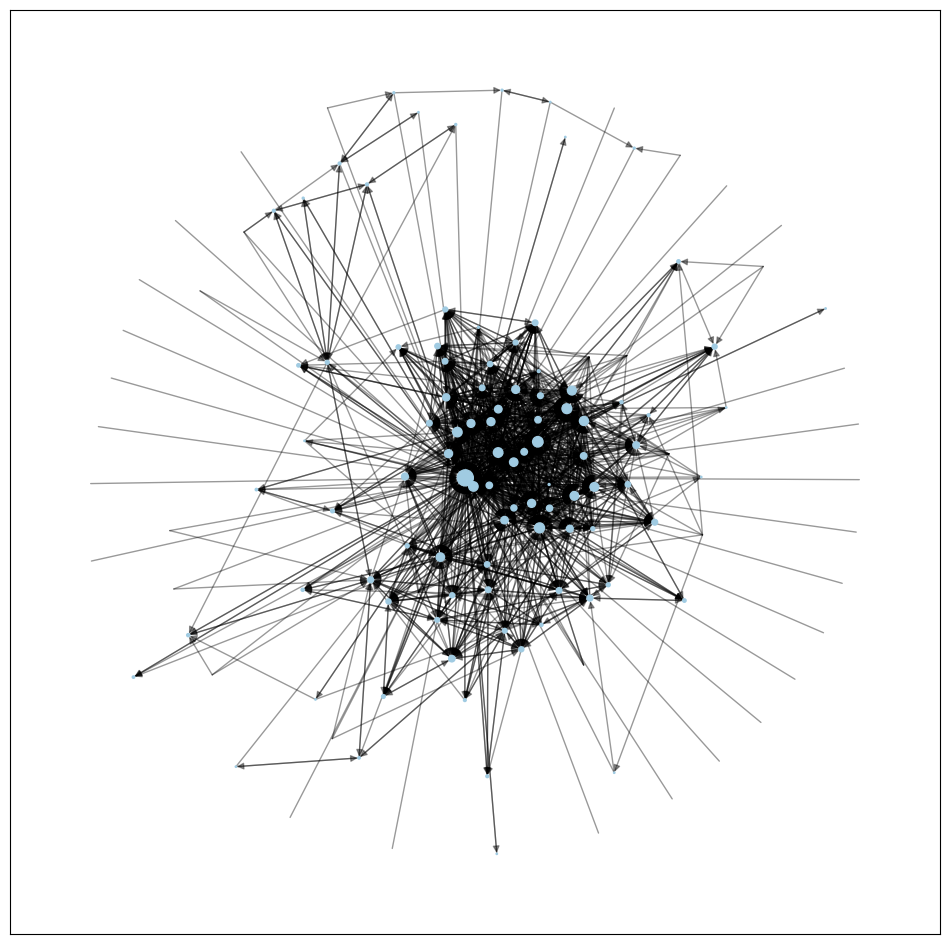

In [16]:
in_degree_weight = []
for node in social_graph.nodes():
    in_degree_weight.append(social_graph.in_degree(node))


nx.draw_networkx(
    social_graph, 
    pos=nx.spring_layout(social_graph),
    node_color='#A0CBE2',
    edge_color=(0,0,0,0.4),
    with_labels=False,
    node_size = in_degree_weight
)
plt.savefig(out_folder+"/social_graph.pdf")
plt.show()

Per il grafo indiretto la dimensione dipende dal grado del nodo 

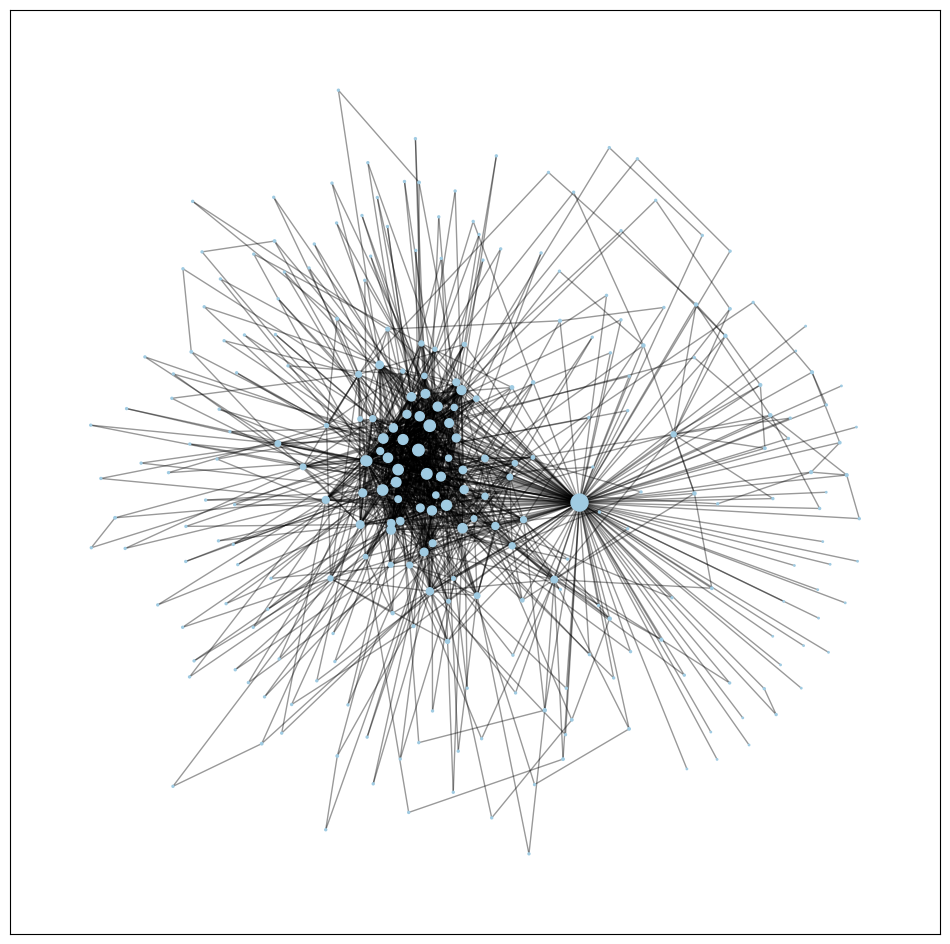

In [13]:
in_degree_weight = []
for node in preferential_graph.nodes():
    in_degree_weight.append(preferential_graph.degree(node))


#rcParams['figure.figsize'] = 12, 12
nx.draw_networkx(
    preferential_graph, 
    pos=nx.spring_layout(preferential_graph),
    node_color='#A0CBE2',
    edge_color = (0,0,0,0.4),
    with_labels=False,
    node_size = in_degree_weight
)
plt.savefig(out_folder+"/preferential_graph.pdf")
plt.show()

### Identificazione della più grande componente fortemente connessa
Per ciascuno dei due grafi, identificare la più grande componente fortemente
connessa SCC e produrre una visualizzazione statica del grafo con una colorazione
rossa dei nodi appartenenti alla SCC, nera per gli altri.

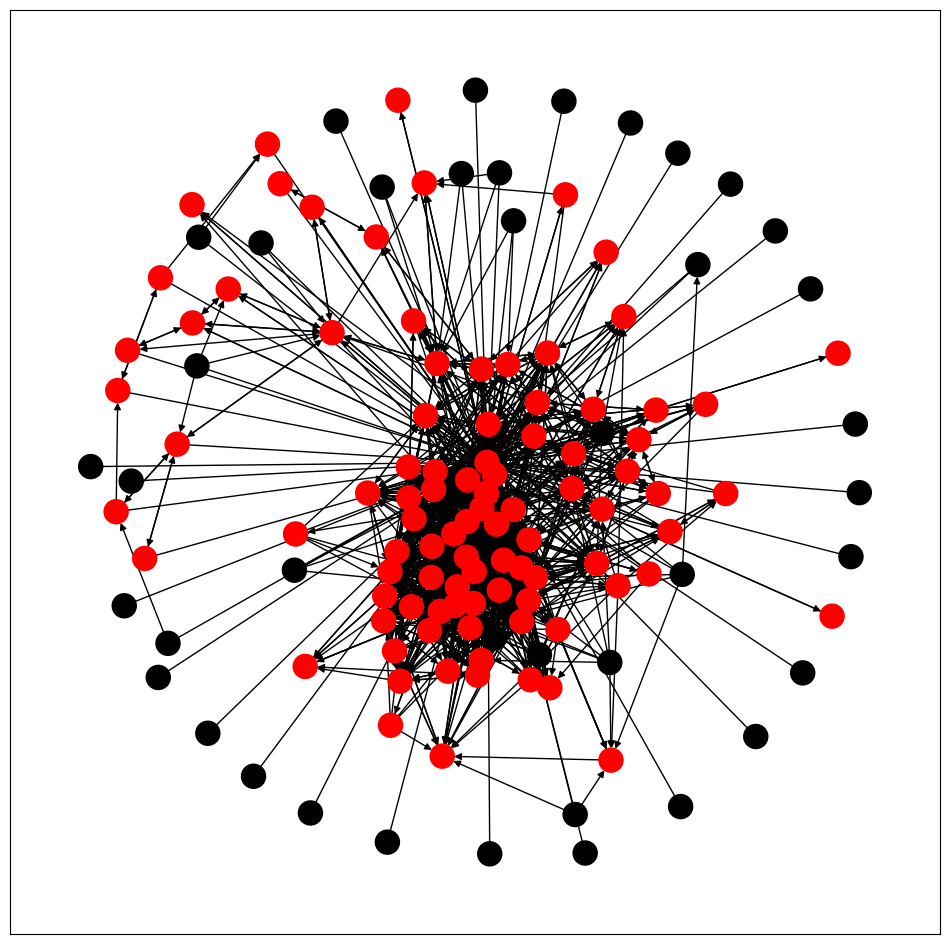

In [17]:
# identifico la SCC più grande
largest = max(nx.strongly_connected_components(social_graph), key=len)
# salvo i nodi appartenenti alla scc
social_scc = nx.subgraph(social_graph, largest)

# specifico una color map, per mappare il colore di ogni nodo come specificato nel testo 
color_map=[]
for node in social_graph:
    if node in largest:
        #se il nodo fa parte della SCC più grande lo coloro di rosso
        color_map.append('red')
    else:
        #se no di nero
        color_map.append('black')

# funzione per disegnare dove utilizzo la color map creata prima
nx.draw_networkx(
    social_graph,
    node_color = color_map,
    with_labels = False
)
plt.savefig(out_folder+"/social_graph_SCC.pdf")

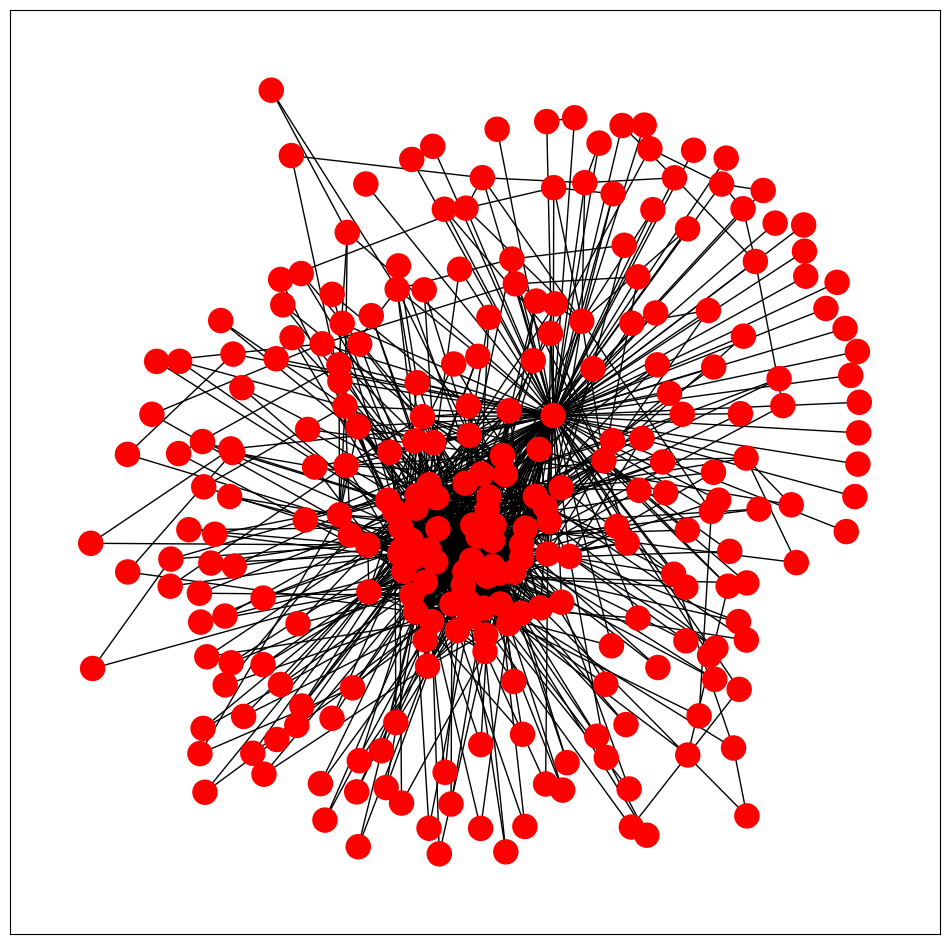

In [18]:
#identifico la SCC più grande
largest = max(nx.connected_components(preferential_graph), key=len)

#specifico una color map, per mappare il colore di ogni nodo come specificato nel testo 
color_map=[]
for node in preferential_graph:
    if node in largest:
        #se il nodo fa parte della SCC più grande lo coloro di rosso
        color_map.append('red')
    else:
        #se no di nero
        color_map.append('black')

#funzione per disegnare dove utilizzo la color map creata prima
nx.draw_networkx(preferential_graph, node_color = color_map, with_labels = False)
plt.savefig(out_folder+"/preferential_graph_SCC.pdf")

### Distanze sui grafi

In [57]:
distances = {}

#centro
distances["center"] = [list(nx.center(social_scc)), list(nx.center(preferential_graph))]
#raggio
distances["radius"] = [nx.radius(social_scc), nx.radius(preferential_graph)]
#distanza media
distances["avarage_distance"] = [nx.average_shortest_path_length(social_graph), nx.average_shortest_path_length(preferential_graph)]
#distanza massima 
distances["max_distance"] = [nx.extrema_bounding(social_scc), nx.extrema_bounding(preferential_graph)]

pd.DataFrame(distances, index=["social_graph", "preferential_graph"])

C:\Users\stefa\AppData\Local\Temp\ipykernel_11160\1785219423.py:10: DeprecationWarning: extrema_bounding is deprecated and will be removed in networkx 3.0
Use nx.diameter(G, usebounds=True) instead.
  distances["max_distance"] = [nx.extrema_bounding(social_scc), nx.extrema_bounding(preferential_graph)]


,center,radius,avarage_distance,max_distance
social_graph,"[3051698888, 1734817550, 3037264899, 2827812417]",4,1.530917,7
preferential_graph,[3036907250],2,2.532786,4


### Calcolo misure di centralità
Calcolare le seguenti misure di centralità sui due grafi: Betweenness centrality, Closeness centrality, Degree centrality, In-degree centrality, Out-degree centrality, Page Rank, HITS

In [79]:
def to_list(dict):
    return list(dict.values())

def compute_centrality_metrics(graph):
    metrics = {}
    # Betweenness
    metrics["betweenness"] = to_list(nx.betweenness_centrality(graph))
    # Closeness
    metrics["closeness"] = to_list(nx.closeness_centrality(graph))
    # Degree
    metrics["degree"] = to_list(nx.degree_centrality(graph))
    # (in/out-degree)
    if(nx.is_directed(graph)):
        metrics["in_degree"] = to_list(nx.in_degree_centrality(graph))
        metrics["out_degree"] = to_list(nx.out_degree_centrality(graph))
    # PageRank
    metrics["pagerank"] = to_list(nx.pagerank(graph))
    # HITS
    metrics["hits"] = to_list(nx.hits(graph)[0])

    return metrics

In [80]:
sg_centrality = compute_centrality_metrics(social_graph)
pg_centrality = compute_centrality_metrics(preferential_graph)

display(pd.DataFrame(sg_centrality, index=social_graph.nodes()))
display(pd.DataFrame(pg_centrality, index=preferential_graph.nodes()))

c:\Users\stefa\anaconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


,betweenness,closeness,degree,in_degree,out_degree,pagerank,hits
3036907250,0.426283,1.000000,1.518797,1.000000,0.518797,0.092158,0.027026
2582519183,0.007576,0.354667,0.052632,0.022556,0.030075,0.002999,0.001661
1558731210570010624,0.000000,0.262327,0.022556,0.007519,0.015038,0.001757,0.001297
998681467696885761,0.002310,0.540650,0.383459,0.150376,0.233083,0.011129,0.020021
1176475874759270400,0.000000,0.000000,0.030075,0.000000,0.030075,0.001119,0.003844
...,...,...,...,...,...,...,...
569382995,0.000000,0.000000,0.030075,0.000000,0.030075,0.001119,0.001382
51023058,0.000066,0.509579,0.052632,0.037594,0.015038,0.004663,0.001484
2827812417,0.022386,0.258755,0.037594,0.015038,0.022556,0.002340,0.001289
1556357336,0.048882,0.515504,0.135338,0.060150,0.075188,0.008115,0.002764


,betweenness,closeness,degree,pagerank,hits
3036907250,0.462734,0.689922,0.550562,0.067109,0.027094
2582519183,0.000082,0.414596,0.014981,0.002179,0.001203
1558731210570010624,0.001065,0.410769,0.011236,0.001999,0.000887
998681467696885761,0.016941,0.507605,0.131086,0.010894,0.015357
1176475874759270400,0.000000,0.424483,0.014981,0.001766,0.002608
...,...,...,...,...,...
263,0.000097,0.329630,0.007491,0.001394,0.000371
264,0.000033,0.356000,0.007491,0.001171,0.000704
265,0.000000,0.356952,0.007491,0.001079,0.001077
266,0.000056,0.313380,0.007491,0.001409,0.000202


### Coefficenti per la stima della small-wordness 
Coefficente omega = (Lr/L) - (C/Cl) 
 - C = coefficente di clustering 
 - L = shortest path medio 
 - Lr = shortest path medio randomico 

Coefficente sigma = (C/Cr) / (L/Lr) 

In [41]:
# i valori sono calcolati solamente per il grafo indiretto 
sigma_value = nx.sigma(preferential_graph)
omega_value = nx.omega(preferential_graph)

KeyboardInterrupt: 